## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

In [ ]:
#!mkdir data
!kg config -g -u imtiaz4ds@gmail.com -p Data@2015 -c planet-understanding-the-amazon-from-space
import os
currentPath=os.getcwd()
#currentPath

os.chdir(currentPath+'/data')
!mkdir planet
os.chdir(currentPath+'/data/planet')
!kg download
#os.getcwd() 

downloading https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/download/train-jpg.tar.7z

train-jpg.tar.7z 100% |#############################| Time: 0:03:34   2.8 MiB/s

downloading https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/download/test-jpg.tar.7z

test-jpg.tar.7z 100% |##############################| Time: 0:07:57   1.3 MiB/s

downloading https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/download/train-tif-v2.tar.7z

train-tif-v2.tar.7z  29% |#######                   | ETA:  1:36:24   1.6 MiB/s

## Multi-label versus single-label classification

In [12]:
from fastai.plots import *

In [13]:
def get_1st(path): return glob(f'{path}/*.*')[0]

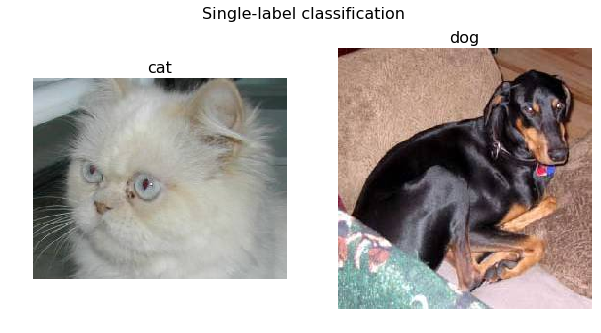

In [14]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

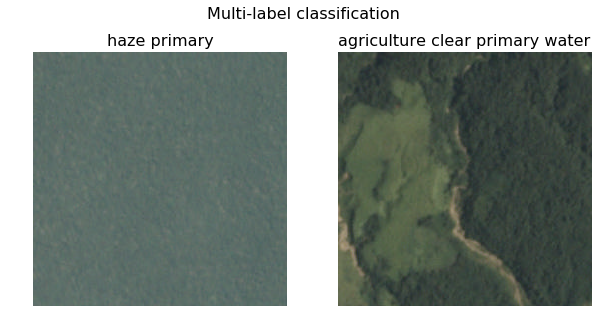

In [15]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [68]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [69]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [70]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [71]:
data = get_data(256)

In [72]:
x,y = next(iter(data.val_dl))

In [9]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [10]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

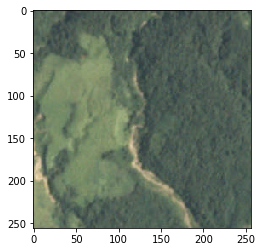

In [11]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [73]:
sz=64

In [74]:
data = get_data(sz)

In [75]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [76]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 0.221569, val_loss: 0.327066, f2: 0.818761



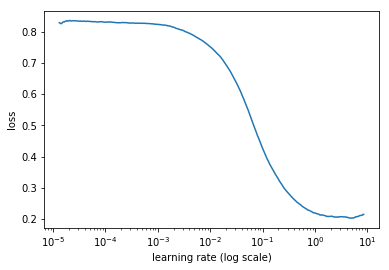

In [16]:
lrf=learn.lr_find()
learn.sched.plot()

In [77]:
lr = 0.2

In [18]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.148107, val_loss: 0.135879, f2: 0.877134
epoch:   1, train_loss: 0.139969, val_loss: 0.130953, f2: 0.882543
epoch:   2, train_loss: 0.133993, val_loss: 0.128145, f2: 0.885481
epoch:   3, train_loss: 0.137495, val_loss: 0.128225, f2: 0.886447
epoch:   4, train_loss: 0.130770, val_loss: 0.125911, f2: 0.888754
epoch:   5, train_loss: 0.130819, val_loss: 0.124939, f2: 0.888910
epoch:   6, train_loss: 0.130466, val_loss: 0.124656, f2: 0.888980



In [78]:
lrs = np.array([lr/9,lr/3,lr])

In [20]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.121678, val_loss: 0.113165, f2: 0.902467
epoch:   1, train_loss: 0.116173, val_loss: 0.109013, f2: 0.906375
epoch:   2, train_loss: 0.109452, val_loss: 0.105840, f2: 0.908508
epoch:   3, train_loss: 0.108599, val_loss: 0.107002, f2: 0.909227
epoch:   4, train_loss: 0.105879, val_loss: 0.103940, f2: 0.911650
epoch:   5, train_loss: 0.101235, val_loss: 0.101751, f2: 0.912528
epoch:   6, train_loss: 0.097978, val_loss: 0.101772, f2: 0.912483



In [21]:
learn.save(f'{sz}')

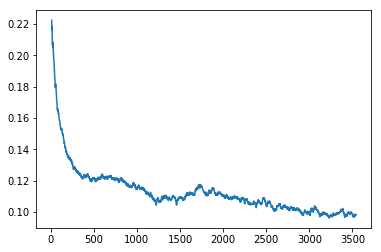

In [22]:
learn.sched.plot_loss()

In [23]:
sz=128

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.098331, val_loss: 0.099193, f2: 0.915188
epoch:   1, train_loss: 0.097878, val_loss: 0.097789, f2: 0.915430
epoch:   2, train_loss: 0.093832, val_loss: 0.096481, f2: 0.916819
epoch:   3, train_loss: 0.099850, val_loss: 0.096562, f2: 0.916488
epoch:   4, train_loss: 0.097125, val_loss: 0.095368, f2: 0.917923
epoch:   5, train_loss: 0.092019, val_loss: 0.095490, f2: 0.917290
epoch:   6, train_loss: 0.093448, val_loss: 0.095308, f2: 0.917381



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.092276, val_loss: 0.090551, f2: 0.922681
epoch:   1, train_loss: 0.092330, val_loss: 0.089372, f2: 0.923794
epoch:   2, train_loss: 0.088824, val_loss: 0.087683, f2: 0.925276
epoch:   3, train_loss: 0.092252, val_loss: 0.091333, f2: 0.922540
epoch:   4, train_loss: 0.087230, val_loss: 0.088938, f2: 0.924605
epoch:   5, train_loss: 0.080835, val_loss: 0.087358, f2: 0.926212
epoch:   6, train_loss: 0.082477, val_loss: 0.086581, f2: 0.926884



In [81]:
sz=256

In [82]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.131109, val_loss: 0.116426, f2: 0.899008
epoch:   1, train_loss: 0.124374, val_loss: 0.110964, f2: 0.904782
epoch:   2, train_loss: 0.122463, val_loss: 0.108716, f2: 0.907693
epoch:   3, train_loss: 0.120318, val_loss: 0.107649, f2: 0.907738
epoch:   4, train_loss: 0.117812, val_loss: 0.106184, f2: 0.909673
epoch:   5, train_loss: 0.110786, val_loss: 0.105101, f2: 0.910997
epoch:   6, train_loss: 0.114606, val_loss: 0.104913, f2: 0.911281



In [83]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.101848, val_loss: 0.092717, f2: 0.923944
epoch:   1, train_loss: 0.095691, val_loss: 0.089632, f2: 0.925673
epoch:   2, train_loss: 0.091526, val_loss: 0.086929, f2: 0.926514
epoch:   3, train_loss: 0.097542, val_loss: 0.091969, f2: 0.920471
epoch:   4, train_loss: 0.090901, val_loss: 0.088462, f2: 0.924966
epoch:   5, train_loss: 0.087770, val_loss: 0.084554, f2: 0.928472
epoch:   6, train_loss: 0.082033, val_loss: 0.084547, f2: 0.928082



In [84]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

In [85]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

### End

In [86]:
preds.shape

(61191, 17)

In [87]:
classes=np.array(data.classes)

In [98]:
predictions=np.where(preds>0.17,1,0)

In [99]:
res=np.array([' '.join(classes[np.where(pp>0)]) for pp in predictions])

In [100]:
filenames =np.array([os.path.basename(f).split('.')[0] for f in data.test_ds.fnames])

In [101]:
res.shape

(61191,)

In [102]:
submissionPlanet=pd.DataFrame(res,index=filenames,columns=['tags'])

In [105]:
subm=f'{PATH}submPlanet/'
os.makedirs(subm)


FileExistsError: [Errno 17] File exists: 'data/planet/submPlanet/'

In [108]:
submissionPlanet.to_csv(f'{subm}submPlanet.gz',compression='gzip',index_label='image_name')
FileLink(f'{subm}submPlanet.gz')

/home/imtiaz/Desktop/fastai/courses/dl1/data/planet/submPlanet/submPlanet.gz